<a href="https://colab.research.google.com/github/bokbokobama/wordle-solver/blob/main/wordleBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wordle Bot by Henry Gelber

### Overview
---
Wordle is a daily word game which challenges its players to find the correct five-letter word with only six tries and minimal feedback. With Wordle Bot, I've attempted to automate the Wordle-solving process using frequency analysis and weighted scoring.

### How to play Wordle (without the bot)
---
To start the game, enter any word, for example:

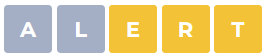

The A and L are gray, which means they don't appear in the word. The E, R, and T are in the word, but aren't in the right spots.

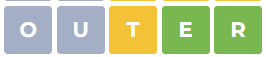

O and U don't appear in the word. T still isn't in the right position, but E and R are.

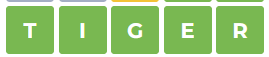

All five letters are green, meaning they're in the correct spots and you've just guessed the word!


### Using the bot
After starting, the bot will output an initial five-letter guess (most likely 'ALERT'). Enter this guess into Wordle, which will give you feedback by coloring each letter black, yellow, or green. 

In the terminal underneath the code block, input the colors of the letters in the form of a string of numbers as follows:

⬛ = 0 $\quad$ 🟨 = 1 $\quad$ 🟩 = 2

For example, 🟩🟨🟩⬛⬛ = 21200

Once you've entered this number and hit enter, the program will generate a new guess. Continue playing until you either win (by entering `22222`) or run out of guesses. 


## Sample Game
---
Code blocks are program output, lines beginning with `>` are user input, and images are game state in Wordle.


`Guess 1: alert (Confidence: 0.0011)`

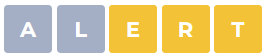

`> 00111`

`Guess 2: outer (Confidence: 0.0373)`

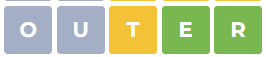

`> 00122`

`Guess 3: tiger (Confidence: 0.3846)`

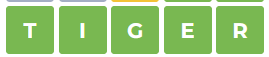

`> 22222`

`Game over, the answer was TIGER`

`You successfully guessed the word in 3 guesses`

In [1]:

##@markdown ## Step 1. Initialize Program
##@markdown Download word lists from https://github.com/bokbokobama/wordle-solver. Then, run this program and upload the lists. You only need to do this once per session.

##@markdown *You can show or hide code by double clicking here.*


##<+><+><+><+><+><+><+><+><+><+>
##1. List Initialization

import os

def wordList(file): # Parses multi-line .txt file into list object
    with open(file,'r') as f:
        words = f.read().splitlines()
    return words

if(os.path.isfile('wordle-answers-alphabetical.txt') == False): # checks whether word lists exist; if not, prompts user to upload txt files
#File upload
  from google.colab import files
  print('Download word lists from https://github.com/bokbokobama/wordle-solver')
  uploaded = files.upload()

# Define lists as variables
answerList = wordList('wordle-answers-alphabetical.txt')
antiWordList = wordList('wordle-allowed-guesses.txt')
mainWordList = wordList('sgb-words.txt')
print('Word lists sucessfully assigned.')

# Initialize general purpose default lists
cleanAlphabet = []
cleanBoardState = []
cleanWordState = ['_', '_', '_', '_', '_'] 

#<+><+><+><+><+><+><+><+><+><+>
# 2. List Validation

# Compares validation sub-functions and removes violating words
def validate(word, wordState, boardState, game):
  if(validateGreen(word, wordState) == True and validateYellow(word, wordState, game) == True and validateBlack(word, boardState) == True):
    return(True)
  else:
    return(False)

# Runs the validate function for every word in the list
def validateIterate(wordList, wordState, boardState, game):
  returnWordList = []
  for word in wordList:
    if(validate(word, wordState, boardState, game) == True):
      returnWordList.append(word)
  return(returnWordList)

# Removes any words which do not have a green letter in the correct spots
def validateGreen(word, wordState):
  for i in range(5):
    if(wordState[i].isupper() == True and word[i].upper() != wordState[i]):
      return(False)
  return(True)

# Removes any words which either do not have a yellow letter or have a yellow letter in the same spot
def validateYellow(word, wordState, game):
  for i in range(5):
    if(wordState[i].islower() == True and wordState[i].lower() not in word):
      return(False)
    try:
      if(wordState[i] == word[i]):
        return(False)
    except:
      print(str(wordState) + str(word))
  return(True)

# Removes any words which contain letters that have already been eliminated
def validateBlack(word, boardState):
  for i in range(26):
    if(boardState[i] == True and chr(i+97) in word):
      return(False)
  return(True)


#<+><+><+><+><+><+><+><+><+><+>
# 3a. Word Score Generation (frequency analysis)
# Counts how often the unique letters in each word appear in other words and returns the highest-scoring


# Counts the frequency of each letter in the current word list
def DistributionScore(wordList):
  letterHits = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

  for word in wordList:
    for letter in word:
      for i in range(26):
          if(letter == chr(i+97)):
            letterHits[i] += 1
            break
  
  return letterHits

# Scores a word based on how often its letters appear in the distribution list. Encourages words with all unique letters.
def simpleWordScore(word, distributionScore):
  score = 0
  for i in range(26):
    if(chr(i+97) in word):
      score += distributionScore[i]
  return(score)

# Runs the wordScore function for every word in the list and returns the best (or worst) word and score.
def simpleWordScoreIterate(wordList, distributionScore, game):
  bestScore = -1
  bestWord = ''
  for word in wordList:
    score = simpleWordScore(word, distributionScore)
    if(score > bestScore):
      bestScore = score
      bestWord = word
  return(bestWord, bestScore)

# Scores a word based on how often its letters appear in the distribution list. Encourages words with all unique letters.
def simpleWordScore(word, distributionScore):
  score = 0
  for i in range(26):
    if(chr(i+97) in word):
      score += distributionScore[i]
  return(score)

#<+><+><+><+><+><+><+><+><+><+>
# 3b. Word Score Generation (greedy min-max)
# Counts the number of yellow and green tiles in each possible answer of each word and returns the highest-scoring word

# Iterates through the word list twice checking the feedback for each word pair and returns the highest-scoring word
def advancedWordScore(word, wordList):
  score = 0
  for testWord in wordList:
    for i in range(5):
      if(word[i]==testWord[i]):
        score += 1
      elif(word[i] in testWord == True):
        score += 1.5
  return(score)

def advancedWordScoreIterate(wordList):
  bestScore = -1
  bestWord = ''
  for word in wordList:
    score = advancedWordScore(word, wordList)
    if(score > bestScore):
      bestScore = score
      bestWord = word
  return(bestWord, bestScore)

#<+><+><+><+><+><+><+><+><+><+>
# 4. User Feedback Request and Parse

# Requests and parses user feedback into a workable format, then identifies and stores green, yellow, and eliminated letters.
def feedbackCheck(word, boardState, checksum, game):
  wordState = ['', '', '', '', '']
  checksum = list(checksum)
  wordFound = False
  output = ['', '', '', '', '']
  tiles = ''
  if(len(checksum)!=5):
    print('Invalid entry, please try again or enter \'ignore\' to skip the word.')
    return(feedbackCheck(word, boardState, input(), game))
  if(checksum == ['2', '2', '2', '2', '2']):
    wordFound = True

  # Black cells
  for i in range(5):
    if(checksum[i] == '0'):
      wordState[i] = '_'
      output[i] = '⬛'
      for j in range(26):
        if(word[i] == chr(j+97)):
          boardState[j] = True

  # Green cells
  for i in range(5):
    if(checksum[i] == '2'):
      wordState[i] = word[i].upper()
      output[i] = '🟩'
      for j in range(26):
        if(word[i] == chr(j+97)):
          boardState[j] = False

  # Yellow cells
  for i in range(5):
    if(checksum[i] == '1'):
      wordState[i] = word[i]
      output[i] = '🟨'
      for j in range(26):
        if(word[i] == chr(j+97)):
          boardState[j] = False
  
  for icon in output:
    tiles += icon
  return(wordState, boardState, wordFound, tiles)


#<+><+><+><+><+><+><+><+><+><+>
# 5. Main Module

# Puts all of the above modules together
def wordleBot(wordList, simulate, answer, algorithm):
  game = 'wordle'
  #wordList = mainWordList
  wordFound = False
  boardState = [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
  wordState = ['_', '_', '_', '_', '_']
  guess = 0

  # Gameplay loop
  bestWord, bestScore = 'slate', len(wordList)*5 # Initial high scoring word to avoid slow iteration of full lists
  while(wordFound == False and guess <= 6):
    guess += 1 # Increment guess
    wordList = validateIterate(wordList, wordState, boardState, game) # Iterate through word list and remove invalid words
    if(bestWord == ''):
      print('Error: no valid word in list.\nRestart the module to play again.')
      break
    if(simulate == False): 
      print('Guess ' + str(guess) + ': ' + bestWord + ' (Confidence: ' + str(round((5*(1/bestScore)), 4)) + ')\n> ', end = '') # Print best scoring word
      wordState,boardState,wordFound, tiles = feedbackCheck(bestWord, boardState, input(), game) # Input and parse user feedback
    else: wordState,boardState,wordFound, tiles = feedbackCheck(bestWord, boardState, wordleSim(answer, bestWord), game) # Input and parse user feedback
    
    if(simulate == False): print(tiles + '\n')
    wordList.remove(bestWord) # Remove the word just guessed to avoid an infinite loop
    wordList = validateIterate(wordList, wordState, boardState, game) # Iterate through word list and remove invalid words
    if(algorithm == 'frequencyAnalysis'):
      distributionScoreList = DistributionScore(wordList) # Update distribution list
      bestWord, bestScore = simpleWordScoreIterate(wordList, distributionScoreList, game) # Find best scoring word
    elif(algorithm == 'greedyMinMax'):
      bestWord, bestScore = advancedWordScoreIterate(wordList)
  if(simulate == False):
    print()
    if(wordFound == True): print('Word found! You found the word ' + bestWord + ' in ' + str(guess) + ' guesses.') # Win condition 
    else: print('You failed to find the correct word in 6 tries.') # Lose condition
    print('Restart the module to play again')
  return(bestWord, guess)
  # End of game


#<+><+><+><+><+><+><+><+><+><+>
# 6. Simulation

def wordleSim(word, guess):
  wordState = ['_', '_', '_', '_', '_']
  returnStr = ''
  for i in range(5):
    try:
      if(guess[i] == word[i]):
        wordState[i] = '2'
      elif(guess[i] in word):
        wordState[i] = '1'
      else:
        wordState[i] = '0'
    except:
      print(guess)
      print(word)
      pass
  for i in wordState:
    returnStr += i
  return returnStr

#<+><+><+><+><+><+><+><+><+><+>
# 7. Accuracy Check

def simulator(algorithm):
  accuracy = [0, 0, 0, 0, 0, 0, 0]
  wordTable = [[],[],[],[],[],[],[]]

  for answer in answerList:
    word, guess = wordleBot(answerList, True, answer, algorithm)
    if(guess <= 6):
      accuracy[guess] += 1
      wordTable[guess].append(answer)
      print('['+str(guess)+'] '+ answer + ' ' + str(accuracy))
    else:
      accuracy[0] += 1
      wordTable[0].append(answer)
      print('[F] '+ answer + ' ' + str(accuracy))
  print(accuracy)
  averageSum = 0
  for i in range(7):
    averageSum += accuracy[i]*i
  print(wordTable[6])
  print(accuracy)
  print('Average number of guesses to solve: ' + str(averageSum/sum(accuracy)) + ' guesses')
  print('Accuracy: ' + str(100*(sum(accuracy[1:6])/sum(accuracy))) + '%')

  

Word lists sucessfully assigned.


In [2]:
#@markdown ##Step 2. Run Interface

#@markdown Daily Wordle : https://www.nytimes.com/games/wordle/index.html

#@markdown Wordle : https://wordlegame.org/ 

#@markdown ⬛ = 0 $\quad$ 🟨 = 1 $\quad$ 🟩 = 2

#@markdown 🟩🟨🟩⬛⬛ = 21200

#@markdown [Default] Frequency Analysis algorithm: avg 3.61 guesses, 96.1% -- fast, scores best words based on how often the letters they contain appear in remaining answers

#@markdown Greedy Min-Max algorithm: avg 3.64 guesses, 97.3% -- slightly slower, scores words based on expected value

#@markdown *Instructions for use can be found below. You can show or hide code by double clicking here.*

#algorithm = "frequencyAnalysis" #@param ["frequencyAnalysis", "greedyMinMax"]
algorithm = "greedyMinMax"
solveForWord = False 
##@param {type:"boolean"}
if(solveForWord == True):
  wordToSolve = 'tiger' 
##@param {type:"string"}
else: wordToSolve = 'blank'

if(wordToSolve in answerList):
  wordleBot(answerList, solveForWord, wordToSolve, algorithm)
else:
  print('Word not found in answer list, please try a different word or change the list used')
# answerList: list of every possible correct answer (recommended)
# mainWordList: uncurated list of five-letter words
# antiWordList: list of every word accepted by Wordle (not recommended)

Guess 1: slate (Confidence: 0.0004)
> 🟨⬛⬛🟩🟨

Guess 2: testy (Confidence: 0.4167)
> ⬛🟩🟩🟩🟩

Guess 3: zesty (Confidence: 1.0)
> Invalid entry, please try again or enter 'ignore' to skip the word.
🟩🟩🟩🟩🟩


Word found! You found the word  in 3 guesses.
Restart the module to play again


### Test cases

**On input mode:**

any string of 0s, 1s, and 2s which is five characters long - should operate normally

a string of five 2s - should print a win message and terminate the program

any alphanumeric string which is < five characters - should reject the string and request a new one

any string of 0s, 1s, and 2s which is >= five characters - should accept the string and run only the first five characters

a string of letters >= 5 characters - should accept string and remove the word from the list, but will not update boardState or wordState

an alphanumeric string containing some 0s, 1s, and 2s >= 5 characters long - should correctly process any 0s, 1s, and 2s in the corresponding positions

**On solver mode:**

A valid five letter word - should operate normally

A valid word of length != 5 - should reject word with rejection message

An invalid word or string of length 5 - should reject word with rejection message



In [4]:
#@markdown ##Simulator
#@markdown Don't play with this unless you know what you're doing

simulator('greedyMinMax')
#simulator('frequencyAnalysis')

[3] aback [0, 0, 0, 1, 0, 0, 0]
[3] abase [0, 0, 0, 2, 0, 0, 0]
[3] abate [0, 0, 0, 3, 0, 0, 0]
[4] abbey [0, 0, 0, 3, 1, 0, 0]
[4] abbot [0, 0, 0, 3, 2, 0, 0]
[4] abhor [0, 0, 0, 3, 3, 0, 0]
[4] abide [0, 0, 0, 3, 4, 0, 0]
[4] abled [0, 0, 0, 3, 5, 0, 0]
[3] abode [0, 0, 0, 4, 5, 0, 0]
[3] abort [0, 0, 0, 5, 5, 0, 0]
[3] about [0, 0, 0, 6, 5, 0, 0]
[4] above [0, 0, 0, 6, 6, 0, 0]
[3] abuse [0, 0, 0, 7, 6, 0, 0]
[3] abyss [0, 0, 0, 8, 6, 0, 0]
[3] acorn [0, 0, 0, 9, 6, 0, 0]
[4] acrid [0, 0, 0, 9, 7, 0, 0]
[3] actor [0, 0, 0, 10, 7, 0, 0]
[2] acute [0, 0, 1, 10, 7, 0, 0]
[3] adage [0, 0, 1, 11, 7, 0, 0]
[3] adapt [0, 0, 1, 12, 7, 0, 0]
[4] adept [0, 0, 1, 12, 8, 0, 0]
[4] admin [0, 0, 1, 12, 9, 0, 0]
[4] admit [0, 0, 1, 12, 10, 0, 0]
[4] adobe [0, 0, 1, 12, 11, 0, 0]
[4] adopt [0, 0, 1, 12, 12, 0, 0]
[4] adore [0, 0, 1, 12, 13, 0, 0]
[4] adorn [0, 0, 1, 12, 14, 0, 0]
[3] adult [0, 0, 1, 13, 14, 0, 0]
[4] affix [0, 0, 1, 13, 15, 0, 0]
[4] afire [0, 0, 1, 13, 16, 0, 0]
[5] afoot [0, 0, 1